<a href="https://colab.research.google.com/github/JoshuaGreeff/Spam-Detection/blob/main/Traditional_NLP_U599.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set Kaggle config and base directory
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
base_dir = '/content/drive/MyDrive/U599 Project'

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Check CUDA status
!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# Install required packages quietly
!pip install -q evaluate datasets skl2onnx onnxruntime

# Imports
import pandas as pd
import numpy as np
import re
import shutil
import time

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

from sklearn.preprocessing import LabelEncoder

import kagglehub

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx
import onnxruntime as ort

import joblib

In [ ]:
# DATA LOADING & CLEANING

# Download dataset from Kaggle and load CSV
dataset_path = kagglehub.dataset_download("subhajournal/phishingemails")
csv_filename = os.path.join(dataset_path, "Phishing_Email.csv")
df = pd.read_csv(csv_filename)
print(df.info())
print(df.head())

# Track data changes through cleaning steps
data_changes = {}
data_changes["Original"] = len(df)
df.drop(columns=["Unnamed: 0"], inplace=True)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
data_changes["After Removing Duplicates & Null"] = len(df)

# Remove noise by filtering out outlier email lengths for each Email Type
df['length'] = df['Email Text'].str.len()
for email_type in df["Email Type"].unique():
    lengths = df.loc[df["Email Type"] == email_type, "length"]
    q1 = lengths.quantile(0.25)
    q3 = lengths.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = lengths[(lengths < lower) | (lengths > upper)].index
    df.drop(index=outliers, inplace=True)
data_changes["After Noise Removal"] = len(df)
df.drop(columns=["length"], inplace=True)
df.reset_index(drop=True, inplace=True)
data_changes["Final"] = len(df)

print("Data Changes Tracking:")
for stage, size in data_changes.items():
    print(f"{stage}: {size} rows")
print(pd.DataFrame(list(data_changes.items()), columns=["Stage", "Row Count"]))

def preprocess_text(text: str) -> str:
    # Lowercase the text
    text = text.lower()
    # Remove special characters and punctuation (retain numbers)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Replace numbers with a hashtag
    text = re.sub(r'\d+', '#', text)
    # Remove extra spaces/newlines
    return re.sub(r'\s+', ' ', text).strip()

df['Email Text'] = df['Email Text'].apply(preprocess_text)

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB
None
   Unnamed: 0                                         Email Text  \
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1           1  the other side of * galicismos * * galicismo *...   
2           2  re : equistar deal tickets are you still avail...   
3           3  \nHello I am your hot lil horny toy.\n    I am...   
4           4  software at incredibly low prices ( 86 % lower...   

       Email Type  
0      Safe Email  
1      Safe Email  
2      Safe Email  
3  Phishing Email  
4  Phishing Email  
Data Changes Tracking:
Original: 18650 rows
After Removing Duplicates & Null: 17538 rows
After Noise Remov

,Email Text,Email Type
0,re # # disc uniformitarianism re # sex lang di...,Safe Email
1,the other side of galicismos galicismo is a sp...,Safe Email
2,re equistar deal tickets are you still availab...,Safe Email
3,hello i am your hot lil horny toy i am the one...,Phishing Email
4,software at incredibly low prices # lower drap...,Phishing Email


In [ ]:
# SPLIT DATA INTO TRAIN/VALID/TEST
train_df, temp_df = train_test_split(df, stratify=df["Email Type"], test_size=0.2, random_state=123)
valid_df, test_df = train_test_split(temp_df, stratify=temp_df["Email Type"], test_size=0.5, random_state=123)
print("Train, Valid, Test shapes:", train_df.shape, valid_df.shape, test_df.shape)

# TEXT VECTORIZATION & MODEL TRAINING

# Use TF-IDF to vectorize email text
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_df['Email Text'])
X_valid = vectorizer.transform(valid_df['Email Text'])
X_test = vectorizer.transform(test_df['Email Text'])

# Labels (assuming "Phishing Email" is the positive class)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df["Email Type"])
y_valid = label_encoder.transform(valid_df["Email Type"])
y_test = label_encoder.transform(test_df["Email Type"])

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Train classifier
rf_model = RandomForestClassifier(random_state=123, n_jobs=-1)
#rf_model = LogisticRegression(max_iter=1000, random_state=123)
#rf_model = MultinomialNB()
start_time = time.time()
rf_model.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Evaluate using F1 score (binary classification; adjust pos_label as needed)
y_pred_valid = rf_model.predict(X_valid)
f1_valid = f1_score(y_valid, y_pred_valid)
print(f"Validation F1 Score: {f1_valid:.4f}")

y_pred_test = rf_model.predict(X_test)
f1_test = f1_score(y_test, y_pred_test)
print(f"Test F1 Score: {f1_test:.4f}")

Train, Valid, Test shapes: (12716, 2) (1589, 2) (1590, 2)
Training Time: 26.17 seconds
Validation F1 Score: 0.9751
Test F1 Score: 0.9684


In [ ]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred  # Extract probabilities and true labels
    predictions = np.argmax(logits, axis=1)  # Get predicted classes

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='binary', pos_label=1)  # Phishing = 1
    recall = recall_score(labels, predictions, average='binary', pos_label=1)
    f1 = f1_score(labels, predictions, average='binary', pos_label=1)

    # Ensure logits[:, 1] exists for AUC & Log Loss calculations
    if logits.shape[1] == 2:
        auc = roc_auc_score(labels, logits[:, 1])
        logloss = log_loss(labels, logits[:, 1])
    else:
        auc = roc_auc_score(labels, predictions)  # Fallback if only class labels
        logloss = log_loss(labels, predictions)

    conf_matrix = confusion_matrix(labels, predictions)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": auc,
        "log_loss": logloss,
        "confusion_matrix": conf_matrix.tolist()
    }

# Predict probabilities and class labels for the test set
y_prob_test = rf_model.predict_proba(X_test)  # Get probabilities
y_pred_test = rf_model.predict(X_test)  # Get class predictions

# Compute metrics
metrics = compute_metrics((y_prob_test, y_test))

# Print metrics
print("Computed Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")

Computed Metrics:
accuracy: 0.959748427672956
precision: 0.9560975609756097
recall: 0.980980980980981
f1: 0.9683794466403162
roc_auc: 0.9918531052202796
log_loss: 0.19409047467856752
confusion_matrix: [[546, 45], [19, 980]]


In [ ]:
def predict_spam(text: str) -> str:
    processed = preprocess_text(text)
    vect = vectorizer.transform([processed])
    pred = rf_model.predict(vect)[0]
    return pred

test1text = "you got a free credit click to this link to get it"
test2text = "hey jack can you send me the invoice from yesterday"

test1result = predict_spam(test1text)
test2result = predict_spam(test2text)

print(f"Test 1 Result: {test1result}")
print(f"Test 2 Result: {test2result}")

test3 = "will u ever come to the company on time"
test3result = predict_spam(test3)
print(f"Test 3 Result: {test3result}")

Test 1 Result: 0
Test 2 Result: 1
Test 3 Result: 1


In [ ]:
# EXPORT MODEL TO ONNX

onnx_file_path = "random_forest_model.onnx"

# Define path to save the TF-IDF Vectorizer
vectorizer_path = "/content/drive/My Drive/U599 Project/ONNX Utils/vectorizer.pkl"
# Define path to save the ONNX
drive_path = os.path.join('/content/drive/My Drive/U599 Project/ONNX Models/', onnx_file_path)

# Specify the expected input type (note: TF-IDF vectorizer returns a dense representation)
initial_type = [('input', FloatTensorType([None, X_train.shape[1]]))]
onnx_model = convert_sklearn(rf_model, initial_types=initial_type)
with open(onnx_file_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

# Verify the ONNX model
onnx_model_loaded = onnx.load(onnx_file_path)
onnx.checker.check_model(onnx_model_loaded)
print(f"ONNX model exported to {onnx_file_path}")

# TEST ONNX MODEL INFERENCE
ort_session = ort.InferenceSession(onnx_file_path)

def predict_spam_onnx(text: str) -> str:
    processed_text = preprocess_text(text)
    vect_input = vectorizer.transform([processed_text]).toarray().astype(np.float32)
    ort_inputs = {ort_session.get_inputs()[0].name: vect_input}
    start_time = time.time()
    ort_outs = ort_session.run(None, ort_inputs)
    end_time = time.time()
    prediction_time = end_time - start_time
    predicted_index = ort_outs[0][0]
    return predicted_index, prediction_time

# Prepare sample input for ONNX inference (using test1text and test2text)
result1, time1 = predict_spam_onnx(test1text)
result2, time2 = predict_spam_onnx(test2text)
print(f"Test 1 Result: {result1} | Same as sklearn: {result1 == test1result} | Time Taken: {time1}")
print(f"Test 2 Result: {result2} | Same as sklearn: {result2 == test2result} | Time Taken: {time2}")
prediction_time = (time1 + time2) / 2

# SAVE THE ONNX MODEL TO GOOGLE DRIVE
os.makedirs(os.path.dirname(drive_path), exist_ok=True)
shutil.copy(onnx_file_path, drive_path)
print(f"ONNX model saved to: {drive_path}")

# Save the TF-IDF Vectorizer
os.makedirs(os.path.dirname(vectorizer_path), exist_ok=True)
joblib.dump(vectorizer, vectorizer_path)
print(f"TF-IDF Vectorizer saved to: {vectorizer_path}")

ONNX model exported to random_forest_model.onnx
Test 1 Result: 0 | Same as sklearn: True | Time Taken: 0.0012149810791015625
Test 2 Result: 1 | Same as sklearn: True | Time Taken: 0.0004899501800537109
ONNX model saved to: /content/drive/My Drive/U599 Project/ONNX Models/random_forest_model.onnx
TF-IDF Vectorizer saved to: /content/drive/My Drive/U599 Project/ONNX Utils/vectorizer.pkl


In [ ]:
print("Metrics:")
print(f"Total training time: {training_time:.2f} seconds (CPU)")
print(f"Total predicting time: {prediction_time:.5f} seconds")
print(f"Accuracy (F1 Score): {f1_test:.4f}")

Metrics:
Total training time: 26.17 seconds (CPU)
Total predicting time: 0.00085 seconds
Accuracy (F1 Score): 0.9684


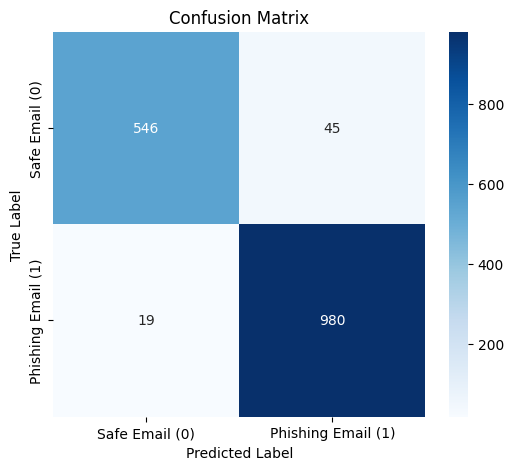

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert confusion matrix to NumPy array
conf_matrix = np.array(metrics["confusion_matrix"])

# Plot using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Safe Email (0)", "Phishing Email (1)"],
            yticklabels=["Safe Email (0)", "Phishing Email (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
